# Training in mini-batches

## Why minibatch vs batch gradient descent?

The goal is to get better generalization, smaller validation loss. We want batch size to be as large as possible for efficiency on GPUs, but as small as possible to get the stochastic bouncing around down into lower minima.

* [Tradeoff batch size vs. number of iterations to train a neural network](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)
* [Why mini batch size is better than one single “batch” with all training data?](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data)
* [Revisiting Small Batch Training for Deep Neural Networks](https://arxiv.org/abs/1804.07612)

In [15]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [16]:
def plot_history(history, ax=None, maxy=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    accur = history[:,0]
    val_accur = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_accur))
    ax.plot(accur, label='train_loss')
    ax.plot(val_accur, label='val_loss')
    ax.legend(loc='upper right')

In [17]:
d = load_diabetes()
len(d.data)

442

In [18]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [19]:
n = len(df)
n_test = int(n*0.20)
n_train = n - n_test
df = df.sample(frac=1) # shuffle data
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [20]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [21]:
rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 1193.59 validation MSE 3250.69


In [22]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Minibatch stochastic gradient descent (SGD)

In [32]:
def sgdtrain(model, X_train, X_test, y_train, y_test,
             learning_rate = .5, nepochs=2000, weight_decay=0, batch_size=32,
             trace=True):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    history = []
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            loss = 0
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            loss = torch.mean((y_pred - batch_y)**2)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()
        
        epoch_training_loss /= nbatches # average batch loss

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((epoch_training_loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
        
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {epoch_training_loss:12.3f}   test loss {loss_test:12.3f}")

    print(f"BEST MSE test loss {best_loss:.3f}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    33271.031   test loss    19691.744
Epoch   10 MSE train loss     2878.647   test loss     3294.126
Epoch   20 MSE train loss     2794.868   test loss     3195.069
Epoch   30 MSE train loss     2728.998   test loss     3367.277
Epoch   40 MSE train loss     2603.604   test loss     3067.995
Epoch   50 MSE train loss     2379.520   test loss     2975.626
Epoch   60 MSE train loss     2596.466   test loss     3101.876
Epoch   70 MSE train loss     2326.107   test loss     3287.423
Epoch   80 MSE train loss     2346.525   test loss     3186.554
Epoch   90 MSE train loss     1891.811   test loss     3300.239
Epoch  100 MSE train loss     1864.082   test loss     3220.383
BEST MSE test loss 2878.340
MSE test loss 2878.340


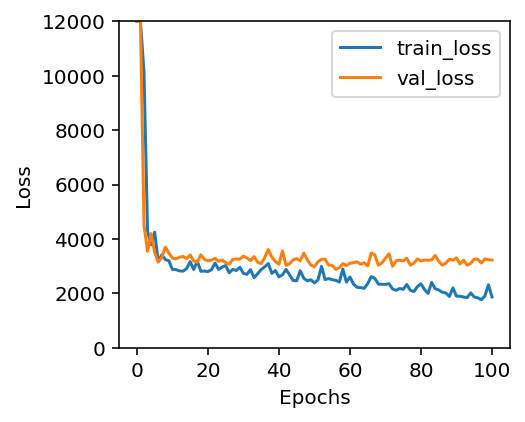

In [56]:
ncols = X.shape[1]
n_neurons = 1000
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons, 1)
)

history, best_model = sgdtrain(model, X_train, X_test, y_train, y_test,
                               learning_rate=.01, nepochs=100, batch_size=32)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))

Epoch    0 MSE train loss     8532.144   test loss     4450.313
Epoch   10 MSE train loss     2253.673   test loss     3396.530
Epoch   20 MSE train loss      799.878   test loss     3273.954
Epoch   30 MSE train loss      236.424   test loss     3328.990
Epoch   40 MSE train loss      434.899   test loss     3466.656
Epoch   50 MSE train loss       76.717   test loss     3252.117
Epoch   60 MSE train loss      261.959   test loss     3336.452
Epoch   70 MSE train loss      237.372   test loss     3447.742
Epoch   80 MSE train loss      184.853   test loss     3369.554
Epoch   90 MSE train loss      120.214   test loss     3295.783
Epoch  100 MSE train loss      413.750   test loss     3568.890
BEST MSE test loss 2840.104
Epoch    0 MSE train loss    10686.244   test loss     4655.125
Epoch   10 MSE train loss     2608.504   test loss     3106.413
Epoch   20 MSE train loss     1670.816   test loss     3596.220
Epoch   30 MSE train loss      616.013   test loss     3549.097
Epoch   40 M

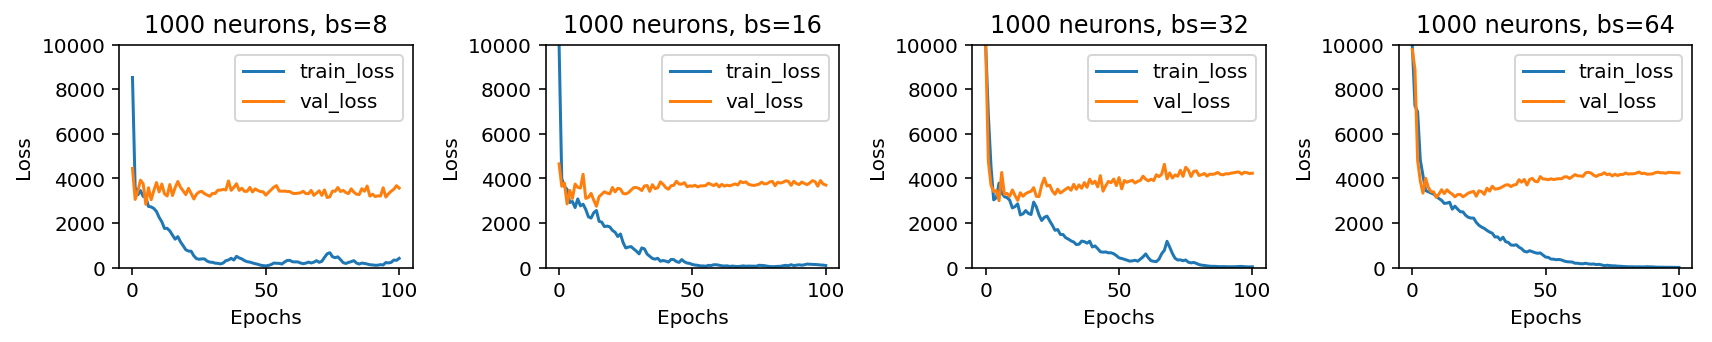

In [58]:
fig, axes = plt.subplots(1, 4,figsize=(12,2.5))

for bs,ax in zip([8,16,32,64],axes):
    model = nn.Sequential(
        nn.Linear(ncols, n_neurons),
        nn.Tanh(),
        nn.Linear(n_neurons, 1)
    )
    history, best_model = sgdtrain(model, X_train, X_test, y_train, y_test,
                                   learning_rate=.05, nepochs=100, batch_size=bs,
                                   trace=True)
    ax.set_title(f"{n_neurons} neurons, bs={bs}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()